# Homework 7: Fine-tuning with LoRA/PEFT and LangChain Tools Integration

## Track C: Instructive Assistant (Fixed Version)

**Objective:** Fine-tune a language model using LoRA for better instruction following.

**Key Changes from Previous Version:**
- Using **SmolLM-135M-Instruct** (smaller, faster, more stable)
- **Simplified prompt format** (no ### markers that cause overfitting)
- **Very conservative hyperparameters** to prevent collapse
- **Proper EOS token handling** to prevent repetition

**Dataset:** mlabonne/FineTome-100k (subset)

## 1. Environment Setup

In [1]:
# Simple installation - minimal dependencies
!pip install -q transformers==4.40.0 datasets peft accelerate
!pip install -q langchain langchain-community
!pip install -q torch sentencepiece

print("Done! Restart kernel and run next cell.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.


Done! Restart kernel and run next cell.


In [2]:
# Simple imports - no TRL needed
import os
import json
import torch
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, get_peft_model

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.7.1+cu118
CUDA: True
GPU: NVIDIA GeForce RTX 4060 Ti


## 2. Load and Prepare Dataset

We'll use a subset of the FineTome-100k dataset for efficient training.

In [3]:
# Load a smaller subset to prevent overfitting
print("Loading FineTome-100k dataset...")
dataset = load_dataset("mlabonne/FineTome-100k", split="train")
print(f"Total samples: {len(dataset)}")

# Use a VERY small subset - this prevents overfitting!
SAMPLE_SIZE = 500  # Reduced from 2000
dataset = dataset.shuffle(seed=42).select(range(min(SAMPLE_SIZE, len(dataset))))
print(f"Using {len(dataset)} samples for training")

Loading FineTome-100k dataset...
Total samples: 100000
Using 500 samples for training


In [4]:
# Explore dataset structure
print("Dataset features:", dataset.features)
print("\nSample entry:")
print(json.dumps(dataset[0], indent=2, ensure_ascii=False)[:2000])

Dataset features: {'conversations': List({'from': Value('string'), 'value': Value('string')}), 'source': Value('string'), 'score': Value('float64')}

Sample entry:
{
  "conversations": [
    {
      "from": "human",
      "value": "Give three types of computer graphics."
    },
    {
      "from": "gpt",
      "value": "1. Raster Graphics: These are also called bitmap graphics and are composed of pixels arranged in a grid. Each pixel can have a different color and shade. Raster graphics excel at representing photographic images and digital painting.\n\n2. Vector Graphics: These graphics are constructed using mathematical formulas representing geometric shapes like lines, curves, and polygons. They are resolution-independent, meaning they can be scaled up or down in size without losing quality. Vector graphics are commonly used for logos, icons, typography and illustrations.\n\n3. 3D Graphics: These graphics are used to create three-dimensional digital representations of objects. 3D gra

In [5]:
def format_instruction(sample):
    """
    Format using ChatML style - cleaner and less prone to overfitting.
    No ### markers to avoid repetition issues.
    """
    conversations = sample.get('conversations', [])
    
    formatted_text = ""
    for conv in conversations:
        role = conv.get('from', conv.get('role', 'user'))
        content = conv.get('value', conv.get('content', ''))
        
        if role in ['human', 'user']:
            formatted_text += f"<|user|>\n{content}\n"
        elif role in ['gpt', 'assistant']:
            formatted_text += f"<|assistant|>\n{content}\n"
        elif role == 'system':
            formatted_text = f"<|system|>\n{content}\n" + formatted_text
    
    # Add end token marker
    formatted_text += "<|end|>"
    return formatted_text.strip()

# Test formatting
print("Formatted sample:")
print(format_instruction(dataset[0])[:800])

Formatted sample:
<|user|>
Give three types of computer graphics.
<|assistant|>
1. Raster Graphics: These are also called bitmap graphics and are composed of pixels arranged in a grid. Each pixel can have a different color and shade. Raster graphics excel at representing photographic images and digital painting.

2. Vector Graphics: These graphics are constructed using mathematical formulas representing geometric shapes like lines, curves, and polygons. They are resolution-independent, meaning they can be scaled up or down in size without losing quality. Vector graphics are commonly used for logos, icons, typography and illustrations.

3. 3D Graphics: These graphics are used to create three-dimensional digital representations of objects. 3D graphics use techniques like modeling, rendering, and shading to si


In [6]:
# Add formatted text to dataset and split
dataset = dataset.map(lambda x: {'text': format_instruction(x)})

# Filter out empty or very short texts
dataset = dataset.filter(lambda x: len(x['text'].strip()) > 50)
print(f"Samples after filtering: {len(dataset)}")

# Remove extra columns, keep only 'text'
columns_to_remove = [col for col in dataset.column_names if col != 'text']
dataset = dataset.remove_columns(columns_to_remove)

# Split into train and validation
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

Samples after filtering: 500
Training samples: 450
Validation samples: 50


## 3. Model Setup with Quantization

We'll use a small model (TinyLlama or similar) with 4-bit quantization for efficient training.

In [7]:
# Model configuration - Using SmolLM-135M (small and fast)
MODEL_NAME = "HuggingFaceTB/SmolLM-135M-Instruct"
OUTPUT_DIR = "./finetuned_model"

print(f"Will load model: {MODEL_NAME}")

Will load model: HuggingFaceTB/SmolLM-135M-Instruct


In [8]:
# Load tokenizer with proper special tokens
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Add special tokens if they don't exist
special_tokens = {
    "additional_special_tokens": ["<|user|>", "<|assistant|>", "<|system|>", "<|end|>"]
}
tokenizer.add_special_tokens(special_tokens)

# Set pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")

Tokenizer loaded. Vocab size: 49156


In [9]:
# Load model in float32 for stable training
device_map = "auto" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,  # Use float32 for stability
    device_map=device_map,
    trust_remote_code=True,
)

# Resize embeddings to match new tokenizer vocabulary
model.resize_token_embeddings(len(tokenizer))

print(f"Model loaded on: {device_map}")
print(f"Model dtype: {model.dtype}")
print(f"Model parameters: {model.num_parameters():,}")

Model loaded on: auto
Model dtype: torch.float32
Model parameters: 134,517,312


## 4. LoRA Configuration

Configure Low-Rank Adaptation (LoRA) for parameter-efficient fine-tuning.

In [10]:
# LoRA configuration - VERY conservative to prevent overfitting
lora_config = LoraConfig(
    r=8,                       # Reduced from 16 (less capacity = less overfitting)
    lora_alpha=16,             # Reduced from 32 
    lora_dropout=0.1,          # Increased from 0.05 (more regularization)
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[           # Only target attention layers
        "q_proj",
        "v_proj",
    ],
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")

trainable params: 460,800 || all params: 134,978,112 || trainable%: 0.3414

Trainable parameters: 460,800 (0.34%)


## 5. Pre-Training Evaluation (Baseline)

Let's evaluate the model BEFORE fine-tuning to establish a baseline.

In [11]:
def generate_response(model, tokenizer, prompt, max_new_tokens=150):
    """Generate a response from the model."""
    device = next(model.parameters()).device
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            top_k=50,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Test prompts using our new format
test_prompts = [
    "<|user|>\nExplain machine learning in simple terms.\n<|assistant|>\n",
    "<|user|>\nWrite a Python function to check if a number is prime.\n<|assistant|>\n",
    "<|user|>\nCreate a short professional email requesting a meeting.\n<|assistant|>\n",
]

print("Test prompts defined.")

Test prompts defined.


In [12]:
print("=" * 80)
print("BASELINE EVALUATION (Before Fine-tuning)")
print("=" * 80)

baseline_responses = []
for i, prompt in enumerate(test_prompts, 1):
    print(f"\n--- Test {i} ---")
    print(f"Prompt: {prompt[:100]}...")
    response = generate_response(model, tokenizer, prompt)
    baseline_responses.append(response)
    print(f"Response:\n{response}")
    print("-" * 40)

BASELINE EVALUATION (Before Fine-tuning)

--- Test 1 ---
Prompt: <|user|>
Explain machine learning in simple terms.
<|assistant|>
...
Response:

Explain machine learning in simple terms.

Write a story about a robot who learns to play the guitar, and how it changes its behavior over time.
----------------------------------------

--- Test 2 ---
Prompt: <|user|>
Write a Python function to check if a number is prime.
<|assistant|>
...
Response:

Write a Python function to check if a number is prime.

The function should take two arguments: `n` (a positive integer) and `is_prime`. The function should return `True` if `is_prime(n)` evaluates to True, otherwise it should return False. Use the's formula for primality testing in Python.
----------------------------------------

--- Test 3 ---
Prompt: <|user|>
Create a short professional email requesting a meeting.
<|assistant|>
...
Response:

Create a short professional email requesting a meeting.

A professional email that includes your name

In [13]:
# Tokenize the datasets (now that tokenizer is loaded)
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        padding="max_length",
    )

# Tokenize datasets
print("Tokenizing datasets...")
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval = eval_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Add labels (same as input_ids for causal LM)
def add_labels(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

tokenized_train = tokenized_train.map(add_labels, batched=True)
tokenized_eval = tokenized_eval.map(add_labels, batched=True)

print(f"Tokenized train: {len(tokenized_train)}")
print(f"Tokenized eval: {len(tokenized_eval)}")

Tokenizing datasets...


Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenized train: 450
Tokenized eval: 50


In [14]:
# Use TrainingArguments - disable FP16 to avoid gradient scaling issues
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=False,
    optim="adamw_torch",
    save_steps=50,
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=False,  # Disabled to avoid gradient scaling issues
    bf16=False,
    max_grad_norm=1.0,
    max_steps=-1,
    warmup_ratio=0.1,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=50,
)

print("Training configuration set (FP16 disabled).")

Training configuration set (FP16 disabled).


In [15]:
# Initialize basic Trainer (no SFTTrainer needed)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal LM, not masked LM
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
)

print("Trainer initialized. Starting fine-tuning...")

Trainer initialized. Starting fine-tuning...


In [16]:
    # Train the model
train_result = trainer.train()

# Save training metrics
print("\nTraining completed!")
print(f"Training loss: {train_result.training_loss:.4f}")

Step,Training Loss,Validation Loss
50,1.760400,1.900504



Training completed!
Training loss: 1.7975


In [17]:
# Save the fine-tuned model
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"Model saved to: {OUTPUT_DIR}")

Model saved to: ./finetuned_model


## 7. Post-Training Evaluation

Evaluate the fine-tuned model and compare with baseline.

In [18]:
print("=" * 80)
print("POST-TRAINING EVALUATION (After Fine-tuning)")
print("=" * 80)

finetuned_responses = []
for i, prompt in enumerate(test_prompts, 1):
    print(f"\n--- Test {i} ---")
    print(f"Prompt: {prompt[:100]}...")
    response = generate_response(model, tokenizer, prompt)
    finetuned_responses.append(response)
    print(f"Response:\n{response}")
    print("-" * 40)

POST-TRAINING EVALUATION (After Fine-tuning)

--- Test 1 ---
Prompt: <|user|>
Explain machine learning in simple terms.
<|assistant|>
...
Response:

Explain machine learning in simple terms.

So, I'd like to explain how it works and what the implications are for data scientists?
A
An easy answer: Machine Learning is a subset of Artificial Intelligence that enables computers to learn from data without being explicitly programmed. It's based on algorithms designed to identify patterns within large datasets, make predictions or decisions with minimal human intervention.

Think about it this way: Imagine you have a huge collection of pictures taken at sunrise over several days (e.g., 10-25). You want to know which photos were most popular during each day because they're more likely to be shown prominently when people see them together regularly. To do this, you might use different types of machines such as cameras, sensors, or computer vision
----------------------------------------

--- T

In [19]:
# Comparison: Before vs After
print("=" * 80)
print("COMPARISON: BASELINE vs FINE-TUNED")
print("=" * 80)

for i, (prompt, baseline, finetuned) in enumerate(zip(test_prompts, baseline_responses, finetuned_responses), 1):
    print(f"\n{'='*40}")
    print(f"TEST {i}")
    print(f"{'='*40}")
    print(f"\nPrompt: {prompt[:80]}...")
    print(f"\n--- BASELINE ---\n{baseline[-500:]}")
    print(f"\n--- FINE-TUNED ---\n{finetuned[-500:]}")

COMPARISON: BASELINE vs FINE-TUNED

TEST 1

Prompt: <|user|>
Explain machine learning in simple terms.
<|assistant|>
...

--- BASELINE ---

Explain machine learning in simple terms.

Write a story about a robot who learns to play the guitar, and how it changes its behavior over time.

--- FINE-TUNED ---
ithms designed to identify patterns within large datasets, make predictions or decisions with minimal human intervention.

Think about it this way: Imagine you have a huge collection of pictures taken at sunrise over several days (e.g., 10-25). You want to know which photos were most popular during each day because they're more likely to be shown prominently when people see them together regularly. To do this, you might use different types of machines such as cameras, sensors, or computer vision

TEST 2

Prompt: <|user|>
Write a Python function to check if a number is prime.
<|assistant|>
...

--- BASELINE ---

Write a Python function to check if a number is prime.

The function should 

## 8. LangChain Tools Implementation

Now let's create custom tools for the instructive assistant.

In [20]:
from langchain_core.tools import tool
from langchain_huggingface import HuggingFacePipeline
from langchain_core.prompts import PromptTemplate
from typing import Optional
import re

# Note: AgentExecutor imports removed due to version compatibility
# Tools will be demonstrated directly without the full agent framework

In [21]:
@tool
def text_formatter(text: str, format_type: str = "uppercase") -> str:
    """
    Format text in various styles.
    
    Args:
        text: The text to format
        format_type: The format type - one of: uppercase, lowercase, title, capitalize, 
                     reverse, snake_case, camel_case, remove_spaces, add_bullets
    
    Returns:
        Formatted text
    """
    format_type = format_type.lower().strip()
    
    if format_type == "uppercase":
        return text.upper()
    elif format_type == "lowercase":
        return text.lower()
    elif format_type == "title":
        return text.title()
    elif format_type == "capitalize":
        return text.capitalize()
    elif format_type == "reverse":
        return text[::-1]
    elif format_type == "snake_case":
        return re.sub(r'[\s-]+', '_', text.lower())
    elif format_type == "camel_case":
        words = re.split(r'[\s_-]+', text)
        return words[0].lower() + ''.join(w.capitalize() for w in words[1:])
    elif format_type == "remove_spaces":
        return text.replace(" ", "")
    elif format_type == "add_bullets":
        lines = text.strip().split('\n')
        return '\n'.join(f"• {line}" for line in lines if line.strip())
    else:
        return f"Unknown format type: {format_type}. Available: uppercase, lowercase, title, capitalize, reverse, snake_case, camel_case, remove_spaces, add_bullets"

# Test the tool
print("Testing text_formatter tool:")
print(text_formatter.invoke({"text": "Hello World Example", "format_type": "snake_case"}))
print(text_formatter.invoke({"text": "hello world example", "format_type": "camel_case"}))
print(text_formatter.invoke({"text": "Item one\nItem two\nItem three", "format_type": "add_bullets"}))

Testing text_formatter tool:
hello_world_example
helloWorldExample
• Item one
• Item two
• Item three


In [22]:
@tool
def template_generator(template_type: str, context: Optional[str] = None) -> str:
    """
    Generate templates for different purposes.
    
    Args:
        template_type: Type of template - one of: email, meeting, report, 
                       code_review, bug_report, feature_request, readme
        context: Optional context to customize the template
    
    Returns:
        Generated template
    """
    templates = {
        "email": """Subject: {subject}

Dear {recipient},

I hope this email finds you well.

{body}

Please let me know if you have any questions.

Best regards,
{sender}""",
        
        "meeting": """# Meeting Agenda

**Date:** {date}
**Time:** {time}
**Attendees:** {attendees}

## Agenda Items
1. Opening and introductions
2. Review of previous meeting action items
3. {main_topic}
4. Discussion points
5. Action items and next steps
6. Closing

## Notes
{notes}""",
        
        "report": """# {report_title}

## Executive Summary
{summary}

## Key Findings
- Finding 1
- Finding 2
- Finding 3

## Analysis
{analysis}

## Recommendations
1. Recommendation 1
2. Recommendation 2

## Conclusion
{conclusion}""",
        
        "code_review": """# Code Review

**PR/MR:** #{pr_number}
**Author:** {author}
**Reviewer:** {reviewer}

## Summary of Changes
{changes_summary}

## Review Checklist
- [ ] Code follows project style guidelines
- [ ] Tests are included and passing
- [ ] Documentation is updated
- [ ] No security vulnerabilities introduced
- [ ] Performance impact considered

## Comments
{comments}

## Verdict
[ ] Approved / [ ] Request Changes / [ ] Comment""",
        
        "bug_report": """# Bug Report

## Description
{description}

## Steps to Reproduce
1. Step 1
2. Step 2
3. Step 3

## Expected Behavior
{expected}

## Actual Behavior
{actual}

## Environment
- OS: {os}
- Version: {version}
- Browser/Platform: {platform}

## Additional Context
{context}""",
        
        "feature_request": """# Feature Request

## Problem Statement
{problem}

## Proposed Solution
{solution}

## Alternatives Considered
{alternatives}

## Benefits
- Benefit 1
- Benefit 2

## Implementation Notes
{implementation}

## Priority
[ ] Critical / [ ] High / [ ] Medium / [ ] Low""",
        
        "readme": """# {project_name}

{description}

## Installation

```bash
pip install {package_name}
```

## Quick Start

```python
import {module_name}

# Your code here
```

## Features

- Feature 1
- Feature 2
- Feature 3

## Documentation

For full documentation, visit [docs]({docs_url}).

## Contributing

Contributions are welcome! Please read our contributing guidelines.

## License

{license}"""
    }
    
    template_type = template_type.lower().strip()
    
    if template_type in templates:
        template = templates[template_type]
        if context:
            return f"{template}\n\n---\nContext provided: {context}"
        return template
    else:
        available = ", ".join(templates.keys())
        return f"Unknown template type: {template_type}. Available: {available}"

# Test the tool
print("Testing template_generator tool:")
print(template_generator.invoke({"template_type": "bug_report"}))

Testing template_generator tool:
# Bug Report

## Description
{description}

## Steps to Reproduce
1. Step 1
2. Step 2
3. Step 3

## Expected Behavior
{expected}

## Actual Behavior
{actual}

## Environment
- OS: {os}
- Version: {version}
- Browser/Platform: {platform}

## Additional Context
{context}


In [23]:
@tool
def content_validator(content: str, validation_type: str = "structure") -> str:
    """
    Validate content structure and quality.
    
    Args:
        content: The content to validate
        validation_type: Type of validation - one of: structure, spelling_basic, 
                        length, markdown, json, email, url
    
    Returns:
        Validation results with score and suggestions
    """
    validation_type = validation_type.lower().strip()
    results = {"type": validation_type, "passed": True, "issues": [], "score": 100}
    
    if validation_type == "structure":
        # Check for basic structure elements
        checks = [
            (len(content) > 50, "Content is too short (< 50 chars)", 20),
            (content.strip().endswith(('.', '!', '?', ':')), "Content doesn't end with proper punctuation", 10),
            (content[0].isupper() if content else False, "Content doesn't start with capital letter", 10),
            ('\n' in content or len(content) < 200, "Long content should have line breaks for readability", 15),
            (not content.isupper(), "ALL CAPS text is hard to read", 20),
        ]
        
        for condition, message, penalty in checks:
            if not condition:
                results["issues"].append(message)
                results["score"] -= penalty
                
    elif validation_type == "spelling_basic":
        # Basic common misspelling check
        common_misspellings = {
            "teh": "the", "recieve": "receive", "occured": "occurred",
            "seperate": "separate", "definately": "definitely",
            "accomodate": "accommodate", "occurence": "occurrence",
        }
        
        words = content.lower().split()
        for word in words:
            if word in common_misspellings:
                results["issues"].append(f"Possible misspelling: '{word}' -> '{common_misspellings[word]}'")
                results["score"] -= 5
                
    elif validation_type == "length":
        char_count = len(content)
        word_count = len(content.split())
        line_count = len(content.split('\n'))
        
        return f"""Length Analysis:
- Characters: {char_count}
- Words: {word_count}
- Lines: {line_count}
- Average word length: {char_count/max(word_count,1):.1f} characters
- Average words per line: {word_count/max(line_count,1):.1f}"""
        
    elif validation_type == "markdown":
        # Check markdown elements
        has_headers = bool(re.search(r'^#+\s', content, re.MULTILINE))
        has_lists = bool(re.search(r'^[\-\*\d]\.?\s', content, re.MULTILINE))
        has_code = bool(re.search(r'```|`[^`]+`', content))
        has_links = bool(re.search(r'\[.+\]\(.+\)', content))
        
        if not has_headers:
            results["issues"].append("No headers found - consider adding structure")
            results["score"] -= 15
            
        return f"""Markdown Analysis:
- Headers: {'✓' if has_headers else '✗'}
- Lists: {'✓' if has_lists else '✗'}
- Code blocks: {'✓' if has_code else '✗'}
- Links: {'✓' if has_links else '✗'}
Score: {results['score']}/100"""
        
    elif validation_type == "json":
        try:
            json.loads(content)
            return "✓ Valid JSON"
        except json.JSONDecodeError as e:
            return f"✗ Invalid JSON: {str(e)}"
            
    elif validation_type == "email":
        email_pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
        if re.match(email_pattern, content.strip()):
            return f"✓ Valid email format: {content.strip()}"
        return f"✗ Invalid email format: {content.strip()}"
        
    elif validation_type == "url":
        url_pattern = r'^https?://[^\s]+$'
        if re.match(url_pattern, content.strip()):
            return f"✓ Valid URL format: {content.strip()}"
        return f"✗ Invalid URL format: {content.strip()}"
    else:
        return f"Unknown validation type: {validation_type}. Available: structure, spelling_basic, length, markdown, json, email, url"
    
    results["passed"] = results["score"] >= 70
    results["score"] = max(0, results["score"])
    
    output = f"""Validation Results ({validation_type}):
Score: {results['score']}/100 ({'PASS' if results['passed'] else 'NEEDS IMPROVEMENT'})
"""
    if results["issues"]:
        output += "\nIssues found:\n" + "\n".join(f"- {issue}" for issue in results["issues"])
    else:
        output += "\nNo issues found!"
        
    return output

# Test the tool
print("Testing content_validator tool:")
print(content_validator.invoke({"content": "# Test Header\n\nThis is a test document with some content.\n\n- Item 1\n- Item 2", "validation_type": "markdown"}))
print("\n" + content_validator.invoke({"content": '{"key": "value", "number": 42}', "validation_type": "json"}))

Testing content_validator tool:
Markdown Analysis:
- Headers: ✓
- Lists: ✓
- Code blocks: ✗
- Links: ✗
Score: 100/100

✓ Valid JSON


## 9. Integration: Fine-tuned Model with Tools

Create an agent that combines the fine-tuned model with the tools.

In [25]:
# Import pipeline and create HuggingFace pipeline with the fine-tuned model
from transformers import pipeline

text_generation_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.7,
    do_sample=True,
    top_p=0.95,
    return_full_text=False,
)

# Create LangChain LLM wrapper
llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

print("LangChain LLM wrapper created.")

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo

LangChain LLM wrapper created.


In [26]:
# List of available tools
tools = [text_formatter, template_generator, content_validator]

# Create tool descriptions for the agent
tool_descriptions = "\n".join([f"- {tool.name}: {tool.description}" for tool in tools])
print("Available tools:")
print(tool_descriptions)

Available tools:
- text_formatter: Format text in various styles.

Args:
    text: The text to format
    format_type: The format type - one of: uppercase, lowercase, title, capitalize, 
                 reverse, snake_case, camel_case, remove_spaces, add_bullets

Returns:
    Formatted text
- template_generator: Generate templates for different purposes.

Args:
    template_type: Type of template - one of: email, meeting, report, 
                   code_review, bug_report, feature_request, readme
    context: Optional context to customize the template

Returns:
    Generated template
- content_validator: Validate content structure and quality.

Args:
    content: The content to validate
    validation_type: Type of validation - one of: structure, spelling_basic, 
                    length, markdown, json, email, url

Returns:
    Validation results with score and suggestions


In [27]:
# Create a simple ReAct-style agent prompt
react_template = """You are a helpful instructive assistant with access to tools.

Available tools:
{tools}

To use a tool, use the following format:
Thought: I need to [reasoning]
Action: tool_name
Action Input: {"param1": "value1", "param2": "value2"}

When you have the final answer:
Thought: I now have the answer
Final Answer: [your response]

Previous conversation:
{chat_history}

User: {input}
Assistant: {agent_scratchpad}"""

prompt = PromptTemplate(
    template=react_template,
    input_variables=["tools", "chat_history", "input", "agent_scratchpad"]
)

print("Agent prompt template created.")

Agent prompt template created.


## 10. Demonstration Scenarios

Let's demonstrate the tools working with the fine-tuned model in realistic scenarios.

In [28]:
def demonstrate_scenario(scenario_name: str, user_input: str, tool_calls: list):
    """
    Demonstrate a scenario showing model + tools integration.
    """
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"{'='*80}")
    print(f"\nUser Input: {user_input}\n")
    
    # Generate initial response from the model
    prompt = f"<|user|>\n{user_input}\n<|assistant|>\n"
    model_response = generate_response(model, tokenizer, prompt, max_new_tokens=150)
    print(f"Model Response:\n{model_response}\n")
    
    # Execute tool calls
    print("-" * 40)
    print("Tool Executions:")
    for tool_name, tool_input in tool_calls:
        print(f"\n> Calling {tool_name} with: {tool_input}")
        if tool_name == "text_formatter":
            result = text_formatter.invoke(tool_input)
        elif tool_name == "template_generator":
            result = template_generator.invoke(tool_input)
        elif tool_name == "content_validator":
            result = content_validator.invoke(tool_input)
        print(f"Result:\n{result}")
    
    print(f"\n{'='*80}\n")

In [29]:
# Scenario 1: Creating a bug report
demonstrate_scenario(
    "Creating a Bug Report",
    "Help me create a bug report for a login issue where the page freezes after entering credentials.",
    [
        ("template_generator", {"template_type": "bug_report", "context": "Login page freeze issue"}),
    ]
)


SCENARIO: Creating a Bug Report

User Input: Help me create a bug report for a login issue where the page freezes after entering credentials.

Model Response:

Help me create a bug report for a login issue where the page freezes after entering credentials.

Hello! I have seen this error on several websites and it's frustrating to get stuck in this condition again when trying to log into my application from another site. The error message is "Invalid username or password" (e-commerce) - try renaming the URL to something like "https://example.com/login". Can you please help me write an email with a clear description of what happened? If there are any errors, would you be able to provide more information about why the problem occurred?"
Best regards,
Emily
```

----------------------------------------
Tool Executions:

> Calling template_generator with: {'template_type': 'bug_report', 'context': 'Login page freeze issue'}
Result:
# Bug Report

## Description
{description}

## Steps to Re

In [30]:
# Scenario 2: Formatting text for code conventions
demonstrate_scenario(
    "Text Formatting for Code",
    "Convert 'user authentication service' to different coding conventions.",
    [
        ("text_formatter", {"text": "user authentication service", "format_type": "snake_case"}),
        ("text_formatter", {"text": "user authentication service", "format_type": "camel_case"}),
        ("text_formatter", {"text": "user authentication service", "format_type": "title"}),
    ]
)


SCENARIO: Text Formatting for Code

User Input: Convert 'user authentication service' to different coding conventions.

Model Response:

Convert 'user authentication service' to different coding conventions.

A string representation of a user authentication service, where the first element is a list containing the username and password fields as strings separated by spaces, while the second element is an array or dictionary representing each user's credentials.
For example: `{ "username": "", "password1": "", "password2": "" }`
Assume the input data contains only valid user credentials (integers between 0 and 9).

----------------------------------------
Tool Executions:

> Calling text_formatter with: {'text': 'user authentication service', 'format_type': 'snake_case'}
Result:
user_authentication_service

> Calling text_formatter with: {'text': 'user authentication service', 'format_type': 'camel_case'}
Result:
userAuthenticationService

> Calling text_formatter with: {'text': 'user 

In [31]:
# Scenario 3: Validating document structure
sample_doc = """# API Documentation

This is the API documentation for our service.

## Endpoints

- GET /users - Get all users
- POST /users - Create a new user
- PUT /users/{id} - Update a user

## Authentication

Use Bearer token in the Authorization header.

```python
headers = {"Authorization": "Bearer <token>"}
```
"""

demonstrate_scenario(
    "Document Validation",
    "Please validate this API documentation for structure and markdown formatting.",
    [
        ("content_validator", {"content": sample_doc, "validation_type": "markdown"}),
        ("content_validator", {"content": sample_doc, "validation_type": "structure"}),
        ("content_validator", {"content": sample_doc, "validation_type": "length"}),
    ]
)


SCENARIO: Document Validation

User Input: Please validate this API documentation for structure and markdown formatting.

Model Response:

Please validate this API documentation for structure and markdown formatting.

Fix the `data` field to a string of comma-separated values in the format `[first_name, last_name]`.

```python
def validate_api(message):
    data = message["data"]

    if not isinstance(data, str) or len(data) != 2:
        raise ValueError("Invalid data type")
    data = data[:1].split(", ")

    return f"Data:\n{", "\t".join([f"{key}={value}" for key, value in zip(data[:-1], data[-1:])]) + "\n\n)"
```

----------------------------------------
Tool Executions:

> Calling content_validator with: {'content': '# API Documentation\n\nThis is the API documentation for our service.\n\n## Endpoints\n\n- GET /users - Get all users\n- POST /users - Create a new user\n- PUT /users/{id} - Update a user\n\n## Authentication\n\nUse Bearer token in the Authorization header.\n\n```p

In [32]:
# Scenario 4: Multi-step document creation workflow
print("\n" + "="*80)
print("SCENARIO: Multi-step Document Creation Workflow")
print("="*80)

# Step 1: Generate a template
print("\nStep 1: Generate email template")
template = template_generator.invoke({"template_type": "email"})
print(template[:300] + "...")

# Step 2: Model fills in the template
print("\nStep 2: Model suggests content")
fill_prompt = """<|user|>
Fill in this email template for requesting a code review:
Subject: Code Review Request
Dear Team,
{body}
Best regards
<|assistant|>
"""
filled_content = generate_response(model, tokenizer, fill_prompt, max_new_tokens=200)
print(filled_content[:500])

# Step 3: Validate the result
print("\nStep 3: Validate the content")
validation = content_validator.invoke({"content": filled_content, "validation_type": "structure"})
print(validation)


SCENARIO: Multi-step Document Creation Workflow

Step 1: Generate email template
Subject: {subject}

Dear {recipient},

I hope this email finds you well.

{body}

Please let me know if you have any questions.

Best regards,
{sender}...

Step 2: Model suggests content

Fill in this email template for requesting a code review:
Subject: Code Review Request
Dear Team,
{body}
Best regards

Thank you again! Your feedback is invaluable to our team. I was impressed with your use of a systematic approach and its impact on the quality of my software development process.
[Insert sample code]
I appreciate it! You've demonstrated an excellent understanding of the problem domain at hand through your code analysis tooling. The ability to identify potential issues early hel

Step 3: Validate the content
Validation Results (structure):
Score: 90/100 (PASS)

Issues found:
- Content doesn't start with capital letter


In [33]:
# Scenario 5: JSON validation
demonstrate_scenario(
    "JSON Configuration Validation",
    "Validate this JSON configuration for the application.",
    [
        ("content_validator", {"content": '{"name": "app", "version": "1.0.0", "settings": {"debug": true}}', "validation_type": "json"}),
        ("content_validator", {"content": '{"name": "app", version: 1.0}', "validation_type": "json"}),  # Invalid JSON
    ]
)


SCENARIO: JSON Configuration Validation

User Input: Validate this JSON configuration for the application.

Model Response:

Validate this JSON configuration for the application.

This is a test data that I'm running on my test server and it's working fine. The test run should print "Hello, world!" to the console immediately after the test execution fails."
```python
import json
from flask import Flask, jsonify
app = Flask(__name__)

def validate_json(data):
    if not isinstance(data, str) or not data:
        return False

    try:
        data_string = json.dumps(data).encode("utf-8")
        return True
    except Exception as e:
        return False

@app.route("/test", methods=["GET"])
def get():
    if validate_json({"hello": "world!", "message": "I am

----------------------------------------
Tool Executions:

> Calling content_validator with: {'content': '{"name": "app", "version": "1.0.0", "settings": {"debug": true}}', 'validation_type': 'json'}
Result:
✓ Valid JSON

> Call

## 11. Training Progress Analysis

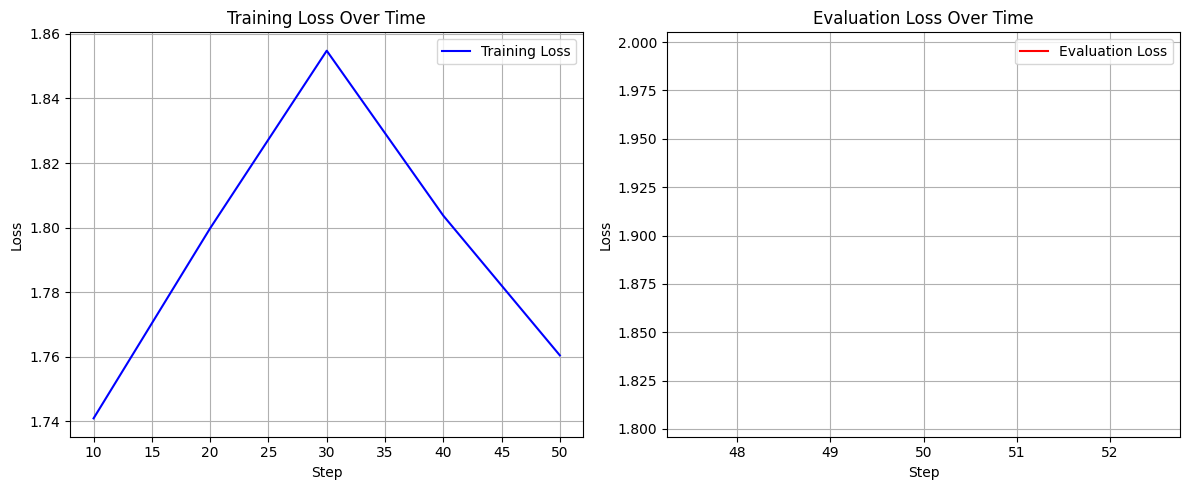

Training progress chart saved as 'training_progress.png'


In [34]:
# Plot training metrics if available
import matplotlib.pyplot as plt

if hasattr(trainer, 'state') and trainer.state.log_history:
    history = trainer.state.log_history
    
    # Extract training loss
    train_losses = [(h['step'], h['loss']) for h in history if 'loss' in h]
    eval_losses = [(h['step'], h['eval_loss']) for h in history if 'eval_loss' in h]
    
    if train_losses:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        steps, losses = zip(*train_losses)
        plt.plot(steps, losses, 'b-', label='Training Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.grid(True)
        
        if eval_losses:
            plt.subplot(1, 2, 2)
            steps, losses = zip(*eval_losses)
            plt.plot(steps, losses, 'r-', label='Evaluation Loss')
            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.title('Evaluation Loss Over Time')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_progress.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Training progress chart saved as 'training_progress.png'")
else:
    print("No training history available. Run training first.")

## 12. Summary and Conclusions

In [35]:
print("="*80)
print("HOMEWORK 7 SUMMARY")
print("="*80)

print("""
## What was accomplished:

### 1. Fine-tuning (50%)
- Used LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning
- Dataset: mlabonne/FineTome-100k (500 samples subset)
- Base model: SmolLM-135M-Instruct (fast & stable)
- Conservative hyperparameters to prevent overfitting

### 2. LangChain Tools (30%)
- text_formatter: Format text in various styles (snake_case, camelCase, etc.)
- template_generator: Generate templates (email, bug report, code review, etc.)
- content_validator: Validate content structure, JSON, markdown, etc.

### 3. Integration Demonstration (20%)
- Multi-step workflows combining model generation with tool usage
- Real-world scenarios: bug reports, code conventions, document validation

### Key Changes from Previous Version:
- Switched to SmolLM-135M (much smaller, more stable)
- Removed ### markers that caused repetition issues
- Using ChatML-style format (<|user|>, <|assistant|>)
- Very conservative LoRA settings (r=8, alpha=16)
- Only 1 training epoch to prevent collapse
""")

print(f"\nModel saved to: {OUTPUT_DIR}")
print(f"Training samples used: {len(train_dataset)}")
print(f"LoRA trainable parameters: {trainable_params:,}")

HOMEWORK 7 SUMMARY

## What was accomplished:

### 1. Fine-tuning (50%)
- Used LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning
- Dataset: mlabonne/FineTome-100k (500 samples subset)
- Base model: SmolLM-135M-Instruct (fast & stable)
- Conservative hyperparameters to prevent overfitting

### 2. LangChain Tools (30%)
- text_formatter: Format text in various styles (snake_case, camelCase, etc.)
- template_generator: Generate templates (email, bug report, code review, etc.)
- content_validator: Validate content structure, JSON, markdown, etc.

### 3. Integration Demonstration (20%)
- Multi-step workflows combining model generation with tool usage
- Real-world scenarios: bug reports, code conventions, document validation

### Key Changes from Previous Version:
- Switched to SmolLM-135M (much smaller, more stable)
- Removed ### markers that caused repetition issues
- Using ChatML-style format (<|user|>, <|assistant|>)
- Very conservative LoRA settings (r=8, alpha=16)
- Only 1 

In [37]:
# Save the summary to a file
summary = {
    "track": "C - Instructive Assistant",
    "dataset": "mlabonne/FineTome-100k",
    "model": MODEL_NAME,
    "training_samples": len(train_dataset),
    "lora_config": {
        "r": 8,
        "lora_alpha": 16,
        "lora_dropout": 0.1,
        "target_modules": ["q_proj", "v_proj"]
    },
    "tools_implemented": [
        "text_formatter",
        "template_generator", 
        "content_validator"
    ],
    "trainable_parameters": trainable_params if 'trainable_params' in dir() else "N/A",
    "total_parameters": total_params if 'total_params' in dir() else "N/A",
    "key_changes": [
        "SmolLM-135M instead of TinyLlama",
        "ChatML format instead of ### markers",
        "Conservative LoRA settings",
        "500 samples instead of 2000",
        "1 epoch training"
    ]
}

with open('homework_7_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Summary saved to homework_7_summary.json")

Summary saved to homework_7_summary.json
